In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
import scipy.optimize as opt

In [90]:
def gaussian_kernel(X, Xprime, gamma=2):
    dists = scipy.spatial.distance.cdist(X, Xprime, metric='sqeuclidean')
    
    return np.exp(-gamma * dists)

def special_kernel(X, Xprime, eta):
    a = eta[0]
    b = eta[1]
    K = (1+X@Xprime.T)**2 + a * np.multiply.outer(np.sin(2*np.pi*X.reshape(-1)+b),np.sin(2*np.pi*Xprime.reshape(-1)+b))
    
    return K

def k_rbf(x, y, l):
    return np.exp(-(x-y)**2/(2*l**2))

In [91]:
#load and normalize Mauna Loa data 
data = np.genfromtxt('co2_mm_mlo.csv', delimiter=',')

#10 years of data for learning
X = data[:120,2]-1958
y_raw = data[:120,3]
y_mean = np.mean(y_raw)
y_std = np.sqrt(np.var(y_raw))
y = (y_raw-y_mean)/y_std

#the next 5 years for prediction
X_predict = data[120:180,2]-1958
y_predict = data[120:180,3]

# Reshape
X = X.reshape((-1, 1))
y_raw = y_raw.reshape((-1, 1))
y = y.reshape((-1, 1))
X_predict = X_predict.reshape((-1, 1))
y_predict = y_predict.reshape((-1, 1))

# b)

In [109]:
def compute_K(kernel, x, eta):
    N = len(x)
    M = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            M[i,j] = kernel(x[i].reshape((1,1)), x[j].reshape((1,1)), eta)
            
    K = M + M.T
    np.fill_diagonal(K, 1)
    
    return(K)

In [110]:
# B) todo: implement this
def negLogLikelihood(params, kernel):
    noise_y = params[0]
    eta = params[1:]
    # todo: calculate the negative loglikelihood (See section 6.3 in the lecture notes)
    
    # Compute the kernel matrix K
    K = compute_K(kernel, X, eta)
    #K = kernel(X, X, eta)

    # Add noise variance to the diagonal
    K_y = K + noise_y**2 * np.eye(len(X))

    # Compute the log determinant and the inverse of K_y
    log_det = np.log(np.linalg.det(K_y))
    K_y_inv = np.linalg.inv(K_y)

    # Calculate the negative log likelihood
    nll = 0.5 * log_det + 0.5 * np.dot(y.T, np.dot(K_y_inv, y)) + 0.5 * len(X) * np.log(2 * np.pi)
    
    return nll

# B) todo: implement the posterior distribution, i.e. the distribution of f^star
def conditional(X, y, noise_var, eta, kernel):
    # todo: Write the function...
    # See eq. 66 in the lecture notes. Note that there is a small error: Instead of (S) it should be K(S)
    
    K = compute_K(kernel, X, eta)
    #K = kernel(X, y, eta)
    
    K_star = kernel(X, y, eta)

    # Add noise variance to the diagonal of K
    K_y = K + noise_var**2 * np.eye(len(X)) # K(S) + sima^2_y*I
    K_y_inv = np.linalg.inv(K_y) # Compute the inverse of K_y

    # Compute the mean of the predictive distribution
    mustar = np.dot(K_star.T, np.dot(K_y_inv, y))

    # Compute the covariance matrix of the predictive distribution
    Sigmastar = kernel(y, y, eta) - np.dot(K_star, np.dot(K_y_inv, K_star.T))

    return mustar, Sigmastar

/var/folders/3m/t5ftv_1d5tj5szs3txjmqx7w0000gn/T/ipykernel_7726/1015515847.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M[i,j] = kernel(x[i].reshape((1,1)), x[j].reshape((1,1)), eta)


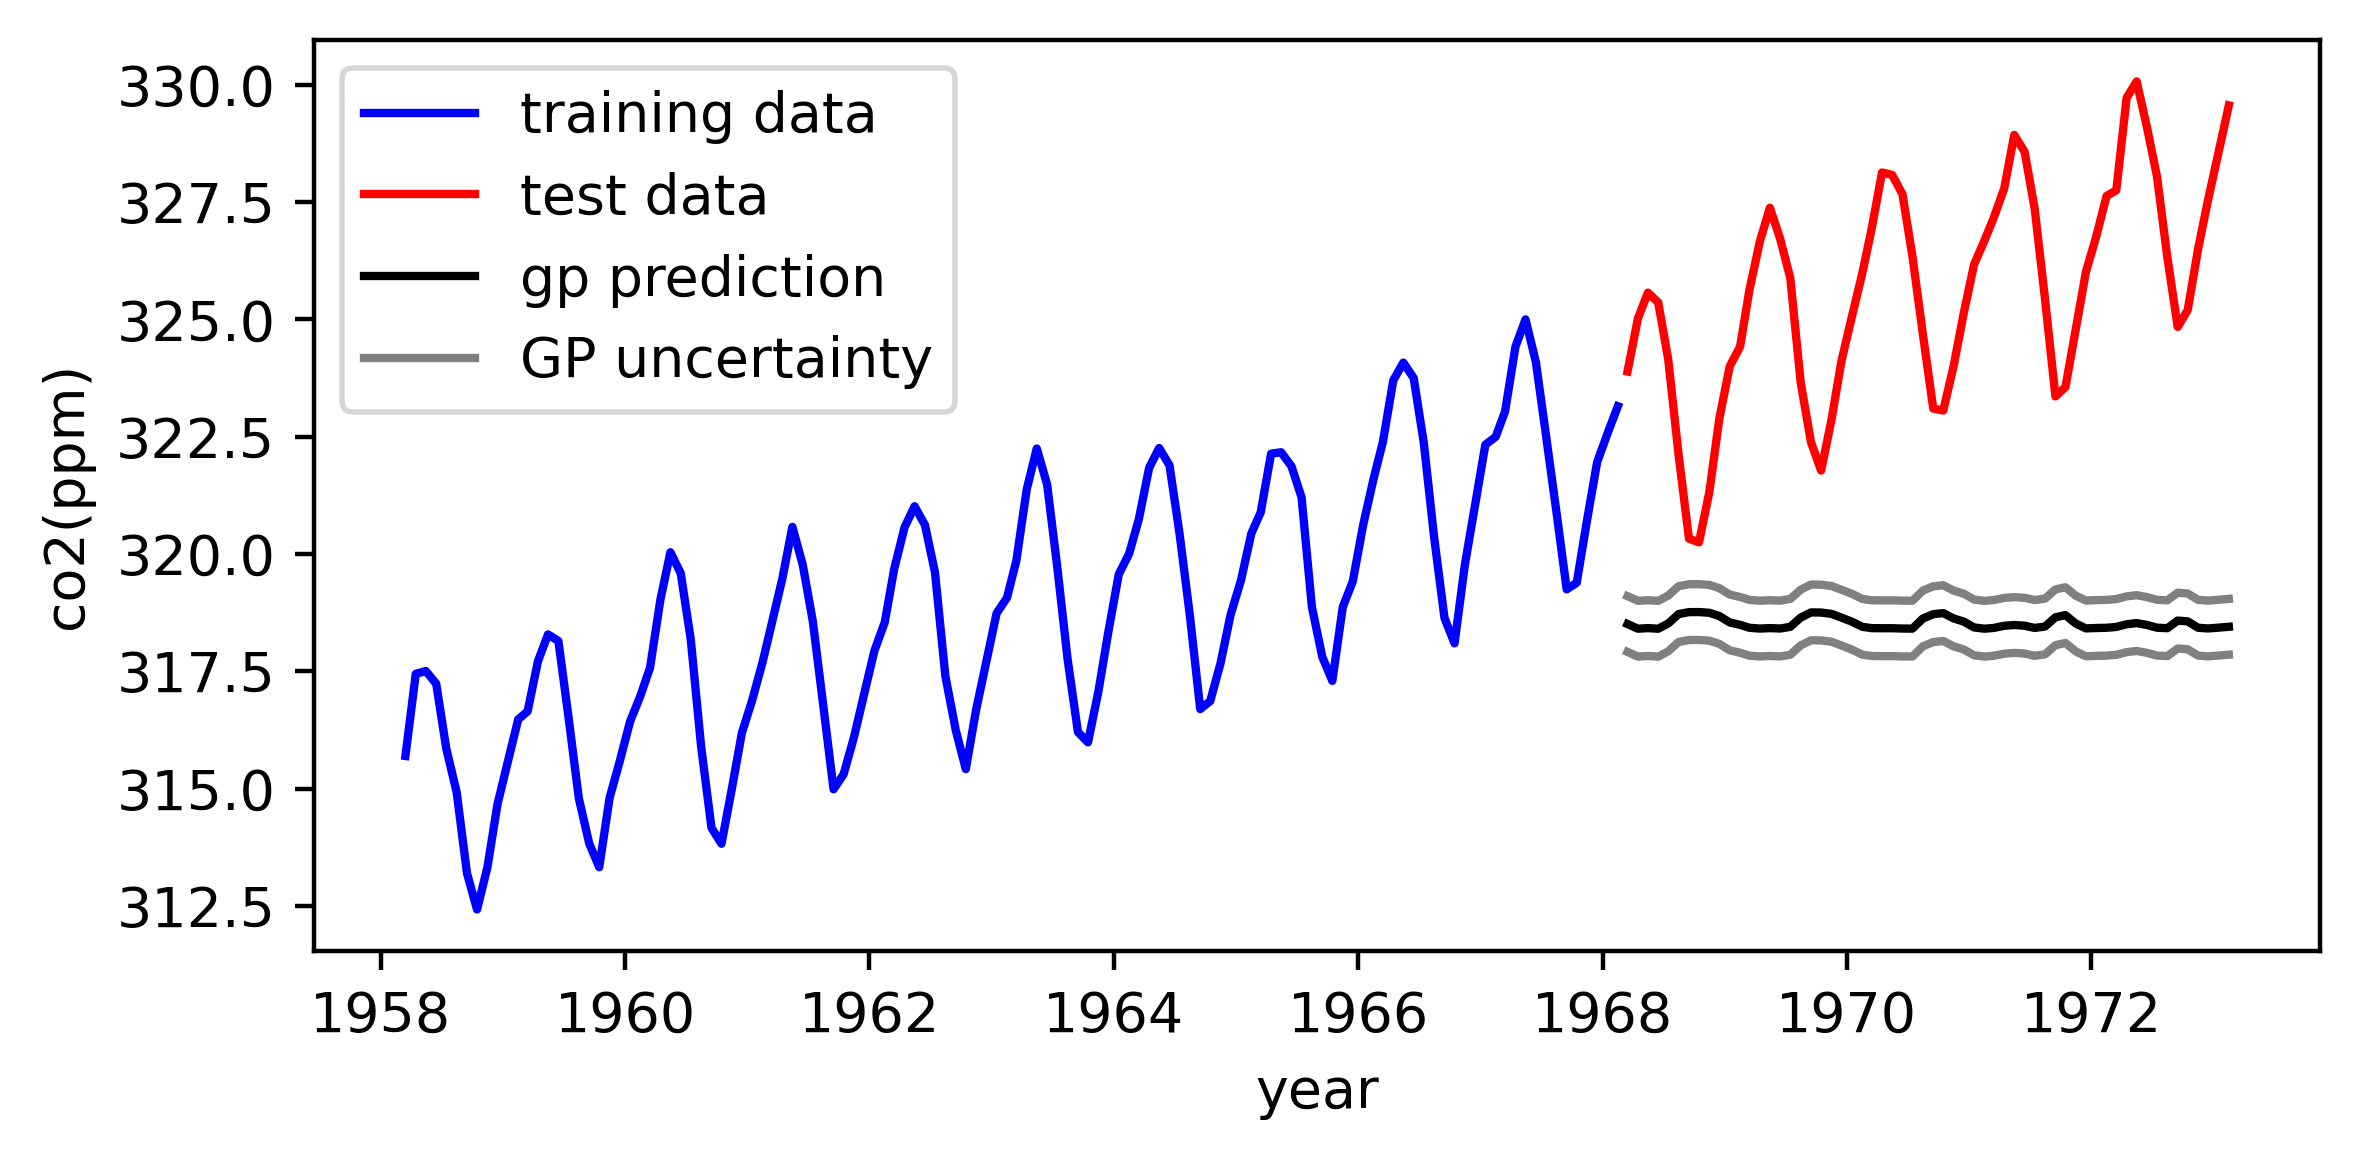

In [137]:
# B) todo: use the learned GP to predict on the observations at X_predict
kernel = gaussian_kernel
noise_var = 10
eta = 2
prediction_mean_gp, Sigma_gp = conditional(X, y, noise_var, eta, kernel)
var_gp = np.diag(Sigma_gp[60:].reshape((1, -1))) # We only need the diagonal term of the covariance matrix for the plots.

#plotting code for your convenience
plt.figure(dpi=400,figsize=(6,3))
plt.plot(X + 1958, y_raw, color='blue', label='training data')
plt.plot(X_predict + 1958, y_predict, color='red', label='test data')

yout_m = prediction_mean_gp[60:] * y_std + y_mean
yout_v = var_gp*y_std**2



plt.plot(X_predict + 1958, yout_m, color='black', label='gp prediction')
plt.plot(X_predict + 1958, yout_m+(1.96*yout_v**0.5), color='grey', label='GP uncertainty')
plt.plot(X_predict + 1958, yout_m-(1.96*yout_v**0.5), color='grey')
plt.xlabel("year")
plt.ylabel("co2(ppm)")
plt.legend()
plt.tight_layout()

# c)

In [122]:
def optimize_params(ranges, kernel, Ngrid):
    opt_params = opt.brute(lambda params: negLogLikelihood(params, kernel), ranges, Ns=Ngrid, finish=None)
    
    noise_var = opt_params[0]
    eta = opt_params[1:]
    
    return noise_var, eta

/var/folders/3m/t5ftv_1d5tj5szs3txjmqx7w0000gn/T/ipykernel_7726/1015515847.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M[i,j] = kernel(x[i].reshape((1,1)), x[j].reshape((1,1)), eta)
/var/folders/3m/t5ftv_1d5tj5szs3txjmqx7w0000gn/T/ipykernel_7726/1470246842.py:15: RuntimeWarning: invalid value encountered in log
  log_det = np.log(np.linalg.det(K_y))


optimal params: 0.01 [0.001  0.0001]


ValueError: x and y must have same first dimension, but have shapes (60, 1) and (120, 1)

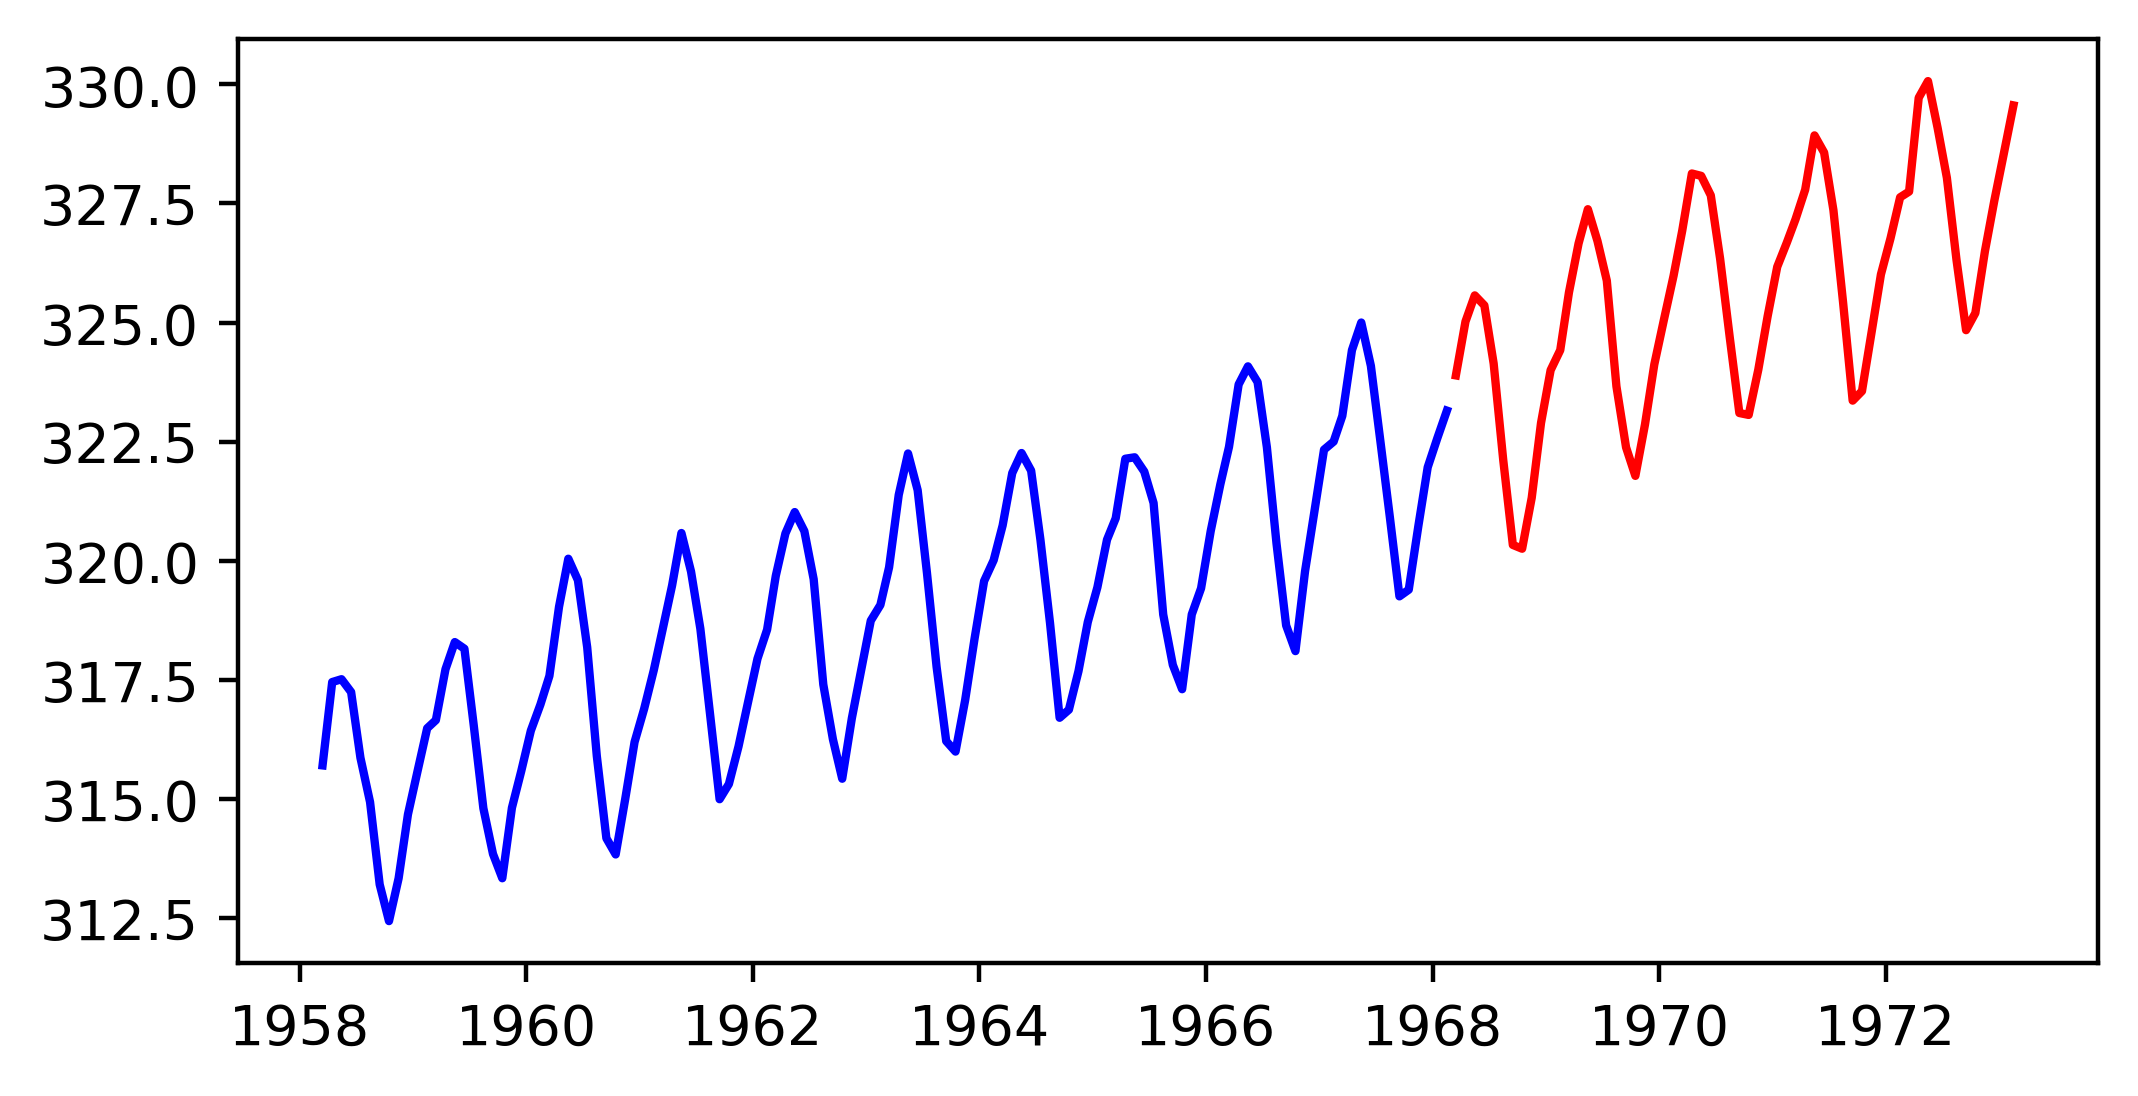

In [138]:
# C) todo: adapt this
kernel = special_kernel # todo: change to new kernel
ranges = ((1.e-2,1), (1.e-3,5), (1.e-4, 10)) # todo: change to the new parameters

Ngrid = 10
noise_var, eta = optimize_params(ranges, kernel, Ngrid)
print("optimal params:", noise_var, eta)

# B) todo: use the learned GP to predict on the observations at X_predict
prediction_mean_gp, Sigma_gp = conditional(X, y, noise_var, eta, kernel)
var_gp = np.diag(Sigma_gp) # We only need the diagonal term of the covariance matrix for the plots.

#plotting code for your convenience
plt.figure(dpi=400,figsize=(6,3))
plt.plot(X + 1958, y_raw, color='blue', label='training data')
plt.plot(X_predict + 1958, y_predict, color='red', label='test data')

yout_m = prediction_mean_gp * y_std + y_mean
yout_v = var_gp*y_std**2

plt.plot(X_predict + 1958, yout_m, color='black', label='gp prediction')
plt.plot(X_predict + 1958, yout_m+1.96*yout_v**0.5, color='grey', label='GP uncertainty')
plt.plot(X_predict + 1958, yout_m-1.96*yout_v**0.5, color='grey')
plt.xlabel("year")
plt.ylabel("co2(ppm)")
plt.legend()
plt.tight_layout()